In [2]:
!pip install -q torchsummary
import os
import pandas as pd
import torch
from torchvision.datasets import ImageFolder 
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [6]:
data_dir = "/kaggle/input/marble-surface-anomaly-detection-2/dataset"
train_dir = "/kaggle/input/marble-surface-anomaly-detection-2/dataset/train"
valid_dir = '/kaggle/input/marble-surface-anomaly-detection-2/dataset/test'


In [7]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [8]:
img,label = train[0]
print(img.shape)

torch.Size([3, 256, 256])


Label :crack(0)


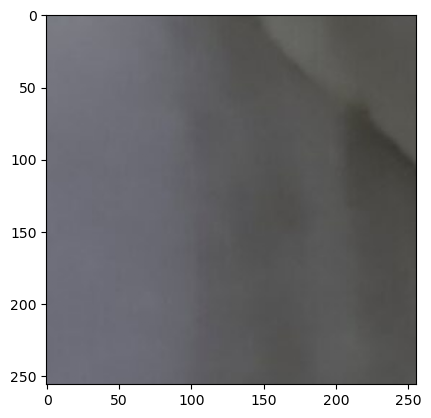

In [9]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
show_image(*train[0])

Label :crack(0)


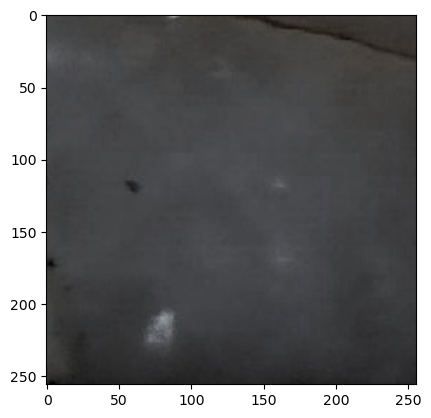

In [16]:
show_image(*valid[100])

In [13]:
torch.manual_seed(7)
batch_size = 32
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid, batch_size, num_workers=2)

In [14]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {'val_loss': loss.detach(), 'val_accuracy': acc}
    
    def validation_epoch_end(self, outputs):
        losses = [x['val_loss'] for x in outputs]
        accuracies = [x['val_accuracy'] for x in outputs]
        avg_loss = torch.stack(losses).mean()
        avg_accuracy = torch.stack(accuracies).mean()
        return {'val_loss': avg_loss, 'val_accuracy': avg_accuracy}
    
    def epoch_end(self, epoch, result):
        last_lr = result['lrs'][-1]
        train_loss = result['train_loss']
        val_loss = result['val_loss']
        val_accuracy = result['val_accuracy']
        
        print(f"Epoch [{epoch}], last_lr: {last_lr:.5f}, "
              f"train_loss: {train_loss:.4f}, "
              f"val_loss: {val_loss:.4f}, "
              f"val_acc: {val_accuracy:.4f}")

In [17]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [22]:
INPUT_SHAPE = (3, 256, 256)
print(summary(model, (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [24]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 1.38 s, sys: 204 ms, total: 1.58 s
Wall time: 2.71 s


[{'val_loss': tensor(1.3880, device='cuda:0'), 'val_accuracy': tensor(0.0625)}]

In [29]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [30]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00276, train_loss: 0.3746, val_loss: 0.4001, val_acc: 0.8139
Epoch [1], last_lr: 0.00758, train_loss: 0.4866, val_loss: 1.1098, val_acc: 0.7443
Epoch [2], last_lr: 0.01000, train_loss: 0.6979, val_loss: 3.3079, val_acc: 0.4489
Epoch [3], last_lr: 0.00950, train_loss: 0.6694, val_loss: 11.5857, val_acc: 0.3509
Epoch [4], last_lr: 0.00812, train_loss: 0.5389, val_loss: 0.6133, val_acc: 0.8054
Epoch [5], last_lr: 0.00611, train_loss: 0.4862, val_loss: 1.0368, val_acc: 0.6761
Epoch [6], last_lr: 0.00389, train_loss: 0.4084, val_loss: 0.3372, val_acc: 0.8835
Epoch [7], last_lr: 0.00188, train_loss: 0.3363, val_loss: 1.2633, val_acc: 0.7415
Epoch [8], last_lr: 0.00050, train_loss: 0.2470, val_loss: 0.2317, val_acc: 0.9134
Epoch [9], last_lr: 0.00000, train_loss: 0.2136, val_loss: 0.2120, val_acc: 0.9247
CPU times: user 2min 31s, sys: 7.83 s, total: 2min 39s
Wall time: 2min 49s


The model has a an accuracy of 92% on the validation dataset

In [39]:
torch.save(model.state_dict(), '/kaggle/working/marble_classification_model.pth')


In [40]:
class_names = train.classes

with open('class_names.txt', 'w') as file:
    file.write('\n'.join(class_names))

In [41]:
train.classes

['crack', 'dot', 'good', 'joint']